This will start with code copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb

My goal is to get practice with a few features:
* Extracting parameters (inversion)
* Custom optimization loops and loss functions

In [1]:
import os

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [4]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


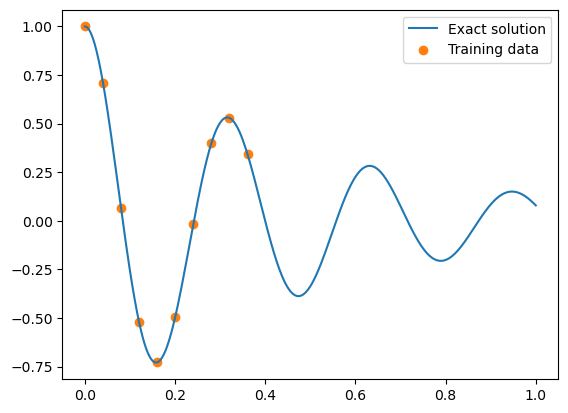

In [5]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [6]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")
    

In [7]:
if not os.path.exists('plots'):
    os.makedirs('plots')

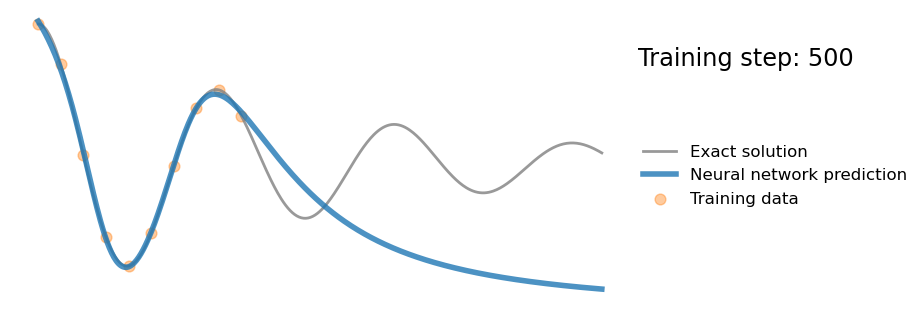

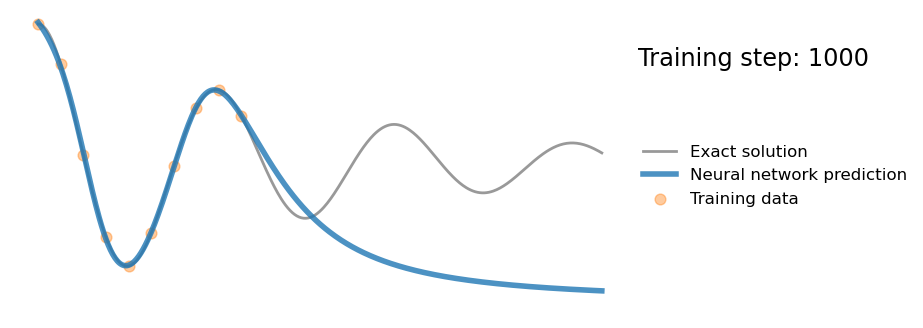

In [8]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
#for i in range(1000):
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("nn.gif", files, fps=20, loop=0)

Physics Informed Neural Network 

True mu, k = 4, 400


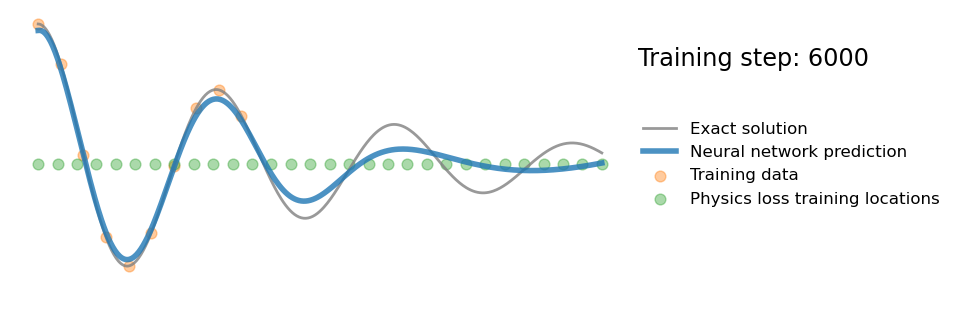

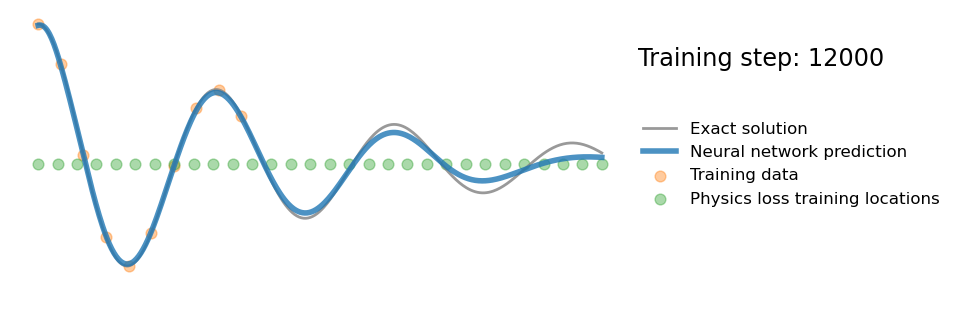

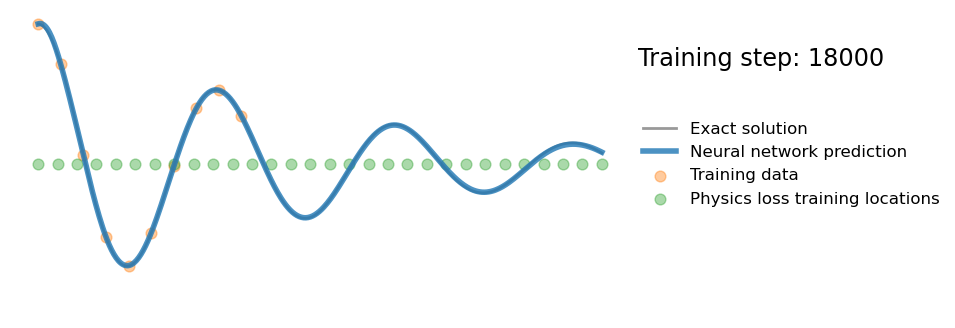

In [9]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2
print(f'True mu, k = {mu}, {k}')

# for reference: i'm currently getting   Extracted mu = 0.045332614332437515, k = -0.001324045704677701

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn.gif", files, fps=20, loop=0)

# My code: $\mu$ and $\it{k}$ as free parameters

  Extracted mu = 23.884891510009766, k = 25.52598762512207
     True mu = 4, k = 400
  Extracted mu = 21.907577514648438, k = 65.77871704101562
     True mu = 4, k = 400
  Extracted mu = 16.843772888183594, k = 112.62854766845703
     True mu = 4, k = 400
  Extracted mu = 9.931778907775879, k = 161.61441040039062
     True mu = 4, k = 400
  Extracted mu = 7.344423770904541, k = 199.8097686767578
     True mu = 4, k = 400
  Extracted mu = 7.45852518081665, k = 226.84439086914062
     True mu = 4, k = 400


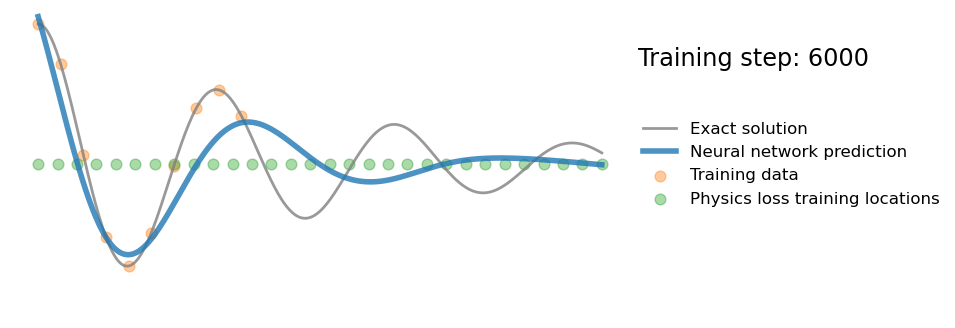

  Extracted mu = 7.501331329345703, k = 250.93963623046875
     True mu = 4, k = 400
  Extracted mu = 6.0360894203186035, k = 278.4971923828125
     True mu = 4, k = 400
  Extracted mu = 5.648586750030518, k = 301.58135986328125
     True mu = 4, k = 400
  Extracted mu = 5.605832099914551, k = 317.9295349121094
     True mu = 4, k = 400
  Extracted mu = 5.375528335571289, k = 331.47314453125
     True mu = 4, k = 400
  Extracted mu = 5.061899662017822, k = 348.1975402832031
     True mu = 4, k = 400


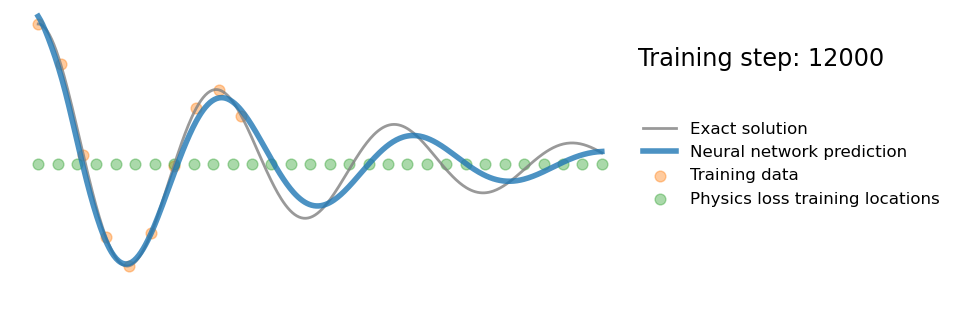

  Extracted mu = 4.819965839385986, k = 364.24859619140625
     True mu = 4, k = 400
  Extracted mu = 4.6258015632629395, k = 375.6405029296875
     True mu = 4, k = 400
  Extracted mu = 4.472469329833984, k = 382.9424743652344
     True mu = 4, k = 400
  Extracted mu = 4.369059085845947, k = 387.6707458496094
     True mu = 4, k = 400
  Extracted mu = 4.291460990905762, k = 390.8159484863281
     True mu = 4, k = 400
  Extracted mu = 4.232666015625, k = 392.8385314941406
     True mu = 4, k = 400


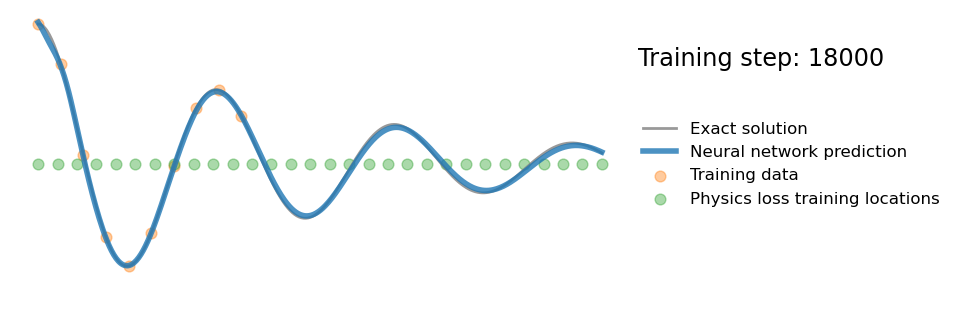

  Extracted mu = 4.194150447845459, k = 394.3197326660156
     True mu = 4, k = 400
  Extracted mu = 4.156496524810791, k = 395.2516174316406
     True mu = 4, k = 400
  Extracted mu = 4.131475448608398, k = 396.02044677734375
     True mu = 4, k = 400
  Extracted mu = 4.110279083251953, k = 396.7272033691406
     True mu = 4, k = 400
  Extracted mu = 4.099761962890625, k = 397.514892578125
     True mu = 4, k = 400
  Extracted mu = 4.087326526641846, k = 397.9269104003906
     True mu = 4, k = 400


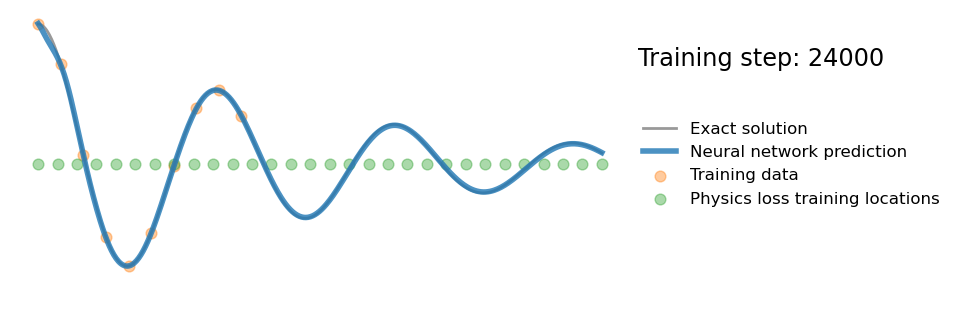

  Extracted mu = 4.079385280609131, k = 398.2206726074219
     True mu = 4, k = 400
  Extracted mu = 4.072917461395264, k = 398.36077880859375
     True mu = 4, k = 400
  Extracted mu = 4.065610885620117, k = 398.3586120605469
     True mu = 4, k = 400
  Extracted mu = 4.064951419830322, k = 398.8145446777344
     True mu = 4, k = 400
  Extracted mu = 4.0652923583984375, k = 398.7303466796875
     True mu = 4, k = 400
  Extracted mu = 4.064491271972656, k = 398.9347229003906
     True mu = 4, k = 400


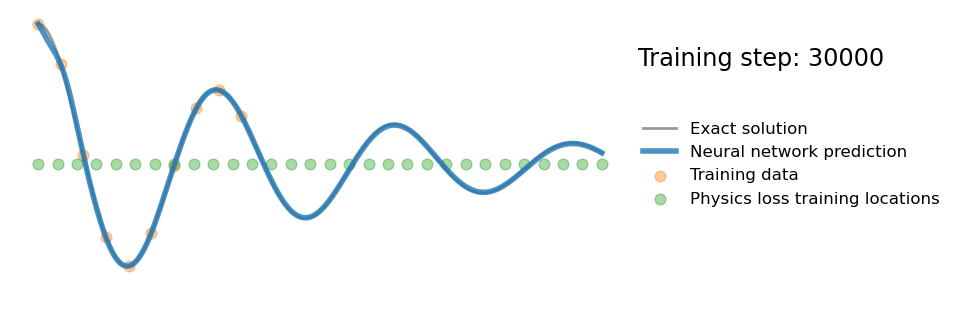

  Extracted mu = 4.063172817230225, k = 398.8204650878906
     True mu = 4, k = 400
  Extracted mu = 4.062082767486572, k = 398.7604064941406
     True mu = 4, k = 400
  Extracted mu = 4.065439701080322, k = 399.0656433105469
     True mu = 4, k = 400
  Extracted mu = 4.0657958984375, k = 399.0928649902344
     True mu = 4, k = 400
  Extracted mu = 4.0719475746154785, k = 398.9887390136719
     True mu = 4, k = 400
  Extracted mu = 4.073307991027832, k = 398.8916931152344
     True mu = 4, k = 400


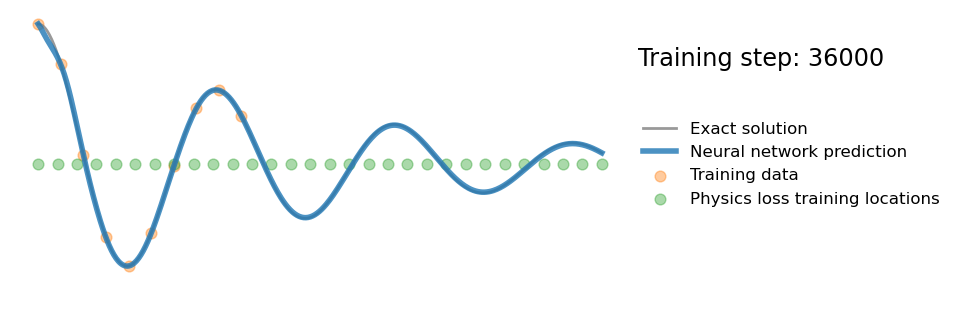

  Extracted mu = 4.075520038604736, k = 398.85931396484375
     True mu = 4, k = 400
  Extracted mu = 4.078773021697998, k = 399.02996826171875
     True mu = 4, k = 400
  Extracted mu = 4.074455261230469, k = 398.76971435546875
     True mu = 4, k = 400
  Extracted mu = 4.069143295288086, k = 398.9307861328125
     True mu = 4, k = 400
  Extracted mu = 4.078926086425781, k = 399.019287109375
     True mu = 4, k = 400
  Extracted mu = 4.079509735107422, k = 398.9900207519531
     True mu = 4, k = 400


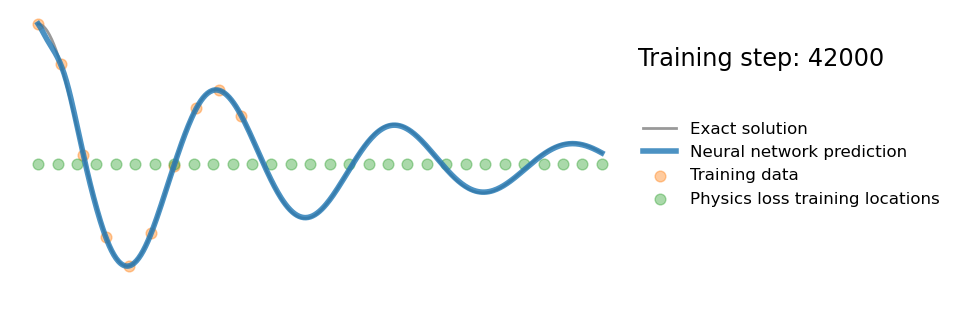

  Extracted mu = 4.079147815704346, k = 398.7886962890625
     True mu = 4, k = 400
  Extracted mu = 4.081620693206787, k = 398.7060546875
     True mu = 4, k = 400
  Extracted mu = 4.077146053314209, k = 398.7580871582031
     True mu = 4, k = 400
  Extracted mu = 4.080451965332031, k = 398.9991455078125
     True mu = 4, k = 400
  Extracted mu = 4.080840587615967, k = 398.9456481933594
     True mu = 4, k = 400
  Extracted mu = 4.082924842834473, k = 398.88385009765625
     True mu = 4, k = 400


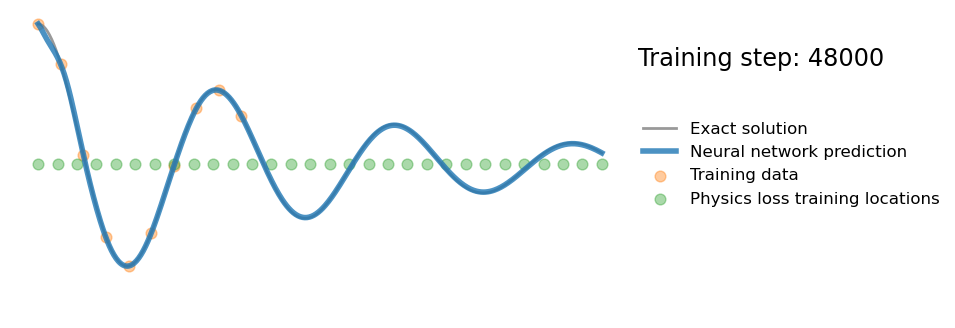

  Extracted mu = 4.080275535583496, k = 398.9526672363281
     True mu = 4, k = 400
  Extracted mu = 4.08126974105835, k = 398.7786865234375
     True mu = 4, k = 400
  Extracted mu = 4.076267719268799, k = 398.80633544921875
     True mu = 4, k = 400
  Extracted mu = 4.080832004547119, k = 398.94647216796875
     True mu = 4, k = 400
  Extracted mu = 4.080135822296143, k = 398.67431640625
     True mu = 4, k = 400
  Extracted mu = 4.081700325012207, k = 398.75445556640625
     True mu = 4, k = 400


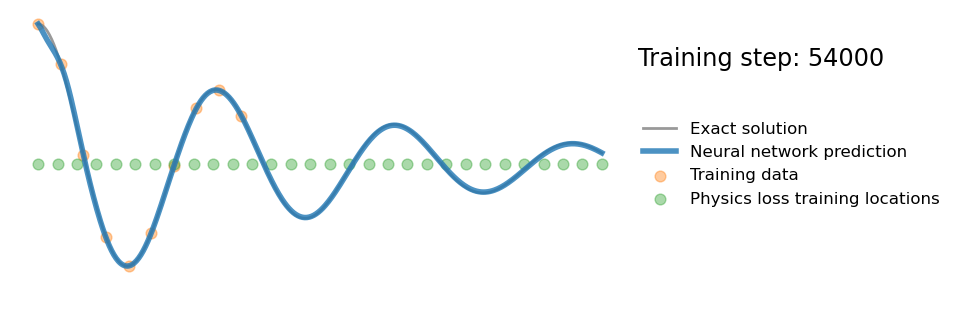

  Extracted mu = 4.082261085510254, k = 398.7215270996094
     True mu = 4, k = 400
  Extracted mu = 4.079419136047363, k = 398.85992431640625
     True mu = 4, k = 400
  Extracted mu = 4.079887390136719, k = 398.83056640625
     True mu = 4, k = 400
  Extracted mu = 4.079596519470215, k = 398.81610107421875
     True mu = 4, k = 400
  Extracted mu = 4.081058025360107, k = 398.7032165527344
     True mu = 4, k = 400
  Extracted mu = 4.082755088806152, k = 398.5815124511719
     True mu = 4, k = 400


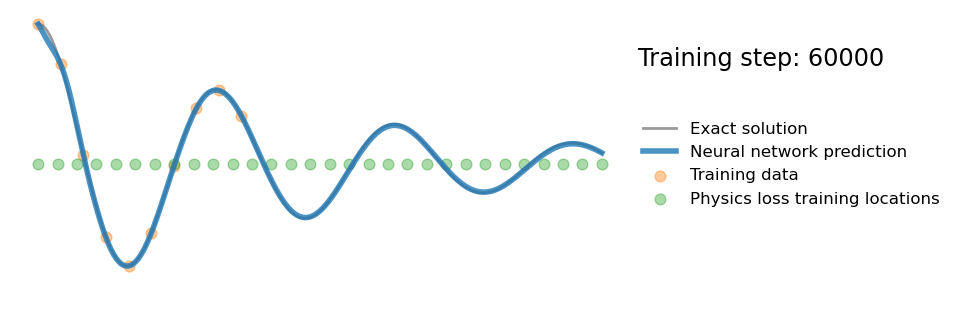

  Extracted mu = 4.080601215362549, k = 398.602294921875
     True mu = 4, k = 400
  Extracted mu = 4.079736709594727, k = 398.5769348144531
     True mu = 4, k = 400
  Extracted mu = 4.0817790031433105, k = 398.51885986328125
     True mu = 4, k = 400
  Extracted mu = 4.0766496658325195, k = 398.76837158203125
     True mu = 4, k = 400
  Extracted mu = 4.078537464141846, k = 398.6552429199219
     True mu = 4, k = 400
  Extracted mu = 4.078097343444824, k = 398.6567077636719
     True mu = 4, k = 400


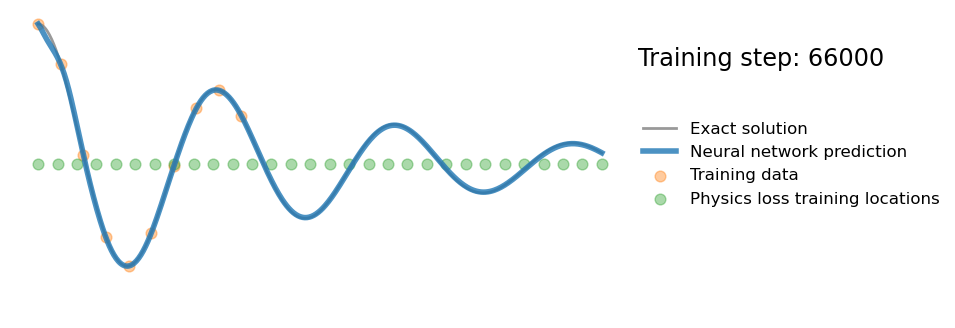

  Extracted mu = 4.0841288566589355, k = 398.5339660644531
     True mu = 4, k = 400
  Extracted mu = 4.074121952056885, k = 398.7265625
     True mu = 4, k = 400
  Extracted mu = 4.080033779144287, k = 398.4521789550781
     True mu = 4, k = 400
  Extracted mu = 4.072644233703613, k = 398.47515869140625
     True mu = 4, k = 400
  Extracted mu = 4.078665733337402, k = 398.5761413574219
     True mu = 4, k = 400
  Extracted mu = 4.078051567077637, k = 398.5917663574219
     True mu = 4, k = 400


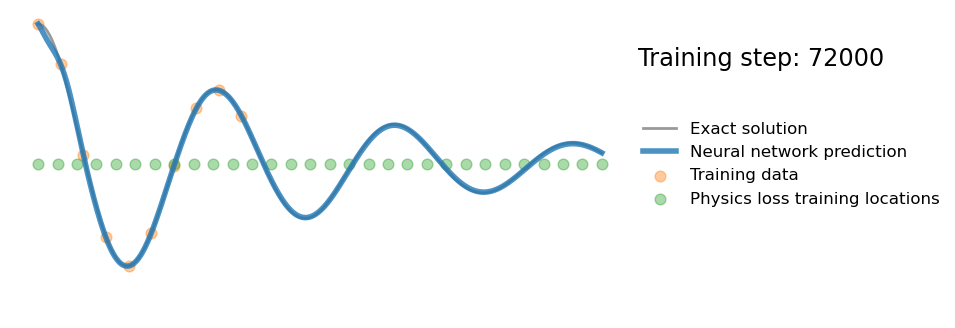

  Extracted mu = 4.075716495513916, k = 398.4695129394531
     True mu = 4, k = 400
  Extracted mu = 4.07392692565918, k = 398.6895446777344
     True mu = 4, k = 400
  Extracted mu = 4.070563793182373, k = 398.6813049316406
     True mu = 4, k = 400
  Extracted mu = 4.071981430053711, k = 398.68487548828125
     True mu = 4, k = 400
  Extracted mu = 4.074171543121338, k = 398.52569580078125
     True mu = 4, k = 400
  Extracted mu = 4.07534646987915, k = 398.4479064941406
     True mu = 4, k = 400


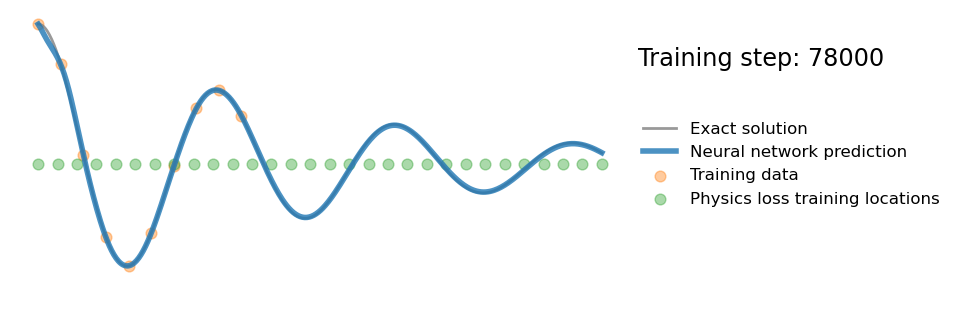

  Extracted mu = 4.076066493988037, k = 398.55279541015625
     True mu = 4, k = 400
  Extracted mu = 4.074924468994141, k = 398.5633544921875
     True mu = 4, k = 400


In [10]:
# add two outputs to the model. The first is still the y-value
# the second and third will be the physical parameters

model = FCN(1,3,32,3)
learning_rate = 1e-3
#learning_rate = 1e-2
physics_prescale = 1e-3 # 1e-4

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
files = []
n_steps,n_draw_steps = 80000,6000
for i in range(n_steps):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    # now yh has three outputs

    # in torch, getting a colum is easy
    # a[:, 1:2], e.g.
    
    yh_y_slice = yh[:,0:1].clone()
    yh_mu_slice = yh[:,1:2].clone()
    yh_k_slice = yh[:,2:3].clone()
    
    loss1 = torch.mean((yh_y_slice-y_data)**2)# use mean squared error
    
    extract_mu = yh_mu_slice[0]
    extract_k = yh_k_slice[0]
    
    if (i+1) % 1000 == 0:
        extract_mu_value = extract_mu.item()
        extract_k_value  = extract_k.item()
        print(f'  Extracted mu = {extract_mu_value}, k = {extract_k_value}')
        print(f'     True mu = {mu}, k = {k}')
    
    # compute the "physics loss"
    yhp_all = model(x_physics)
    yhp = yhp_all[:,0:1].clone()
    
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    new_physics = dx2 + extract_mu*dx + extract_k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    
    loss2 = physics_prescale*torch.mean(new_physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        yh = yh[:,0:1]
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "plots/mynn2_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % n_draw_steps == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("mynn2.gif", files, fps=20, loop=0)